# Goals

* Create a pipeline to gather new datasets from GEO and SRA
* Workflow
  * esearch to find new datasets
  * For GEO records, convert to SRA
  * For each SRA record:
    * Obtain the metadata
      * Sequencing platform
      * Single-end or paired-end?
      * Read lengths
      * Number of reads
      * Publications
    * Obtain the SRR accessions

# Init

In [1]:
import os
import time
import json
from pprint import pprint
from typing import Annotated, List, Dict, Tuple, Optional, Union, Any
import xml.etree.ElementTree as ET
from pydantic import BaseModel, Field
from langchain_core.tools import tool
from Bio import Entrez
import pandas as pd
from dotenv import load_dotenv

In [2]:
from SRAgent.agents.supervisors import create_supervisor_agent, create_step_summary_chain, invoke_entrez_agent

In [3]:
# setup
load_dotenv()
pd.set_option('display.max_colwidth', 1000)
os.environ["DEBUG_MODE"] = "TRUE"

In [4]:
# checks
if os.getenv("DEBUG_MODE") == "TRUE":
    print("DEBUG_MODE is enabled.")

DEBUG_MODE is enabled.


In [5]:
# set up Entrez
Entrez.email = "nick.youngblut@arcinstitute.org"
Entrez.api_key = os.getenv("NCBI_API_KEY")

# Entrez agent

In [6]:
# create supervisor agent
entrez_agent = create_supervisor_agent()
step_summary_chain = create_step_summary_chain()    

In [7]:
# invoke agent
#input = {"messages": [("user", "Convert GSE121737 to SRX accessions")]}
#invoke_entrez_agent(input, entrez_agent, step_summary_chain)

In [8]:
entrez_id = "35966237"
content = f"Obtain SRX accessions associated with Entrez ID {entrez_id}"
input = {"messages": [("user", content)]}
# invoke_entrez_agent(input, entrez_agent, step_summary_chain)

In [9]:
SRX_id = "SRX4967527"
content = f"Obtain SRR accessions associated with {SRX_id}"
input = {"messages": [("user", content)]}
# invoke_entrez_agent(input, entrez_agent, step_summary_chain)

# Subgraph

In [10]:
import operator
from enum import Enum
from typing import Annotated, Sequence, Tuple, Union, Required, TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.types import Send
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import create_react_agent, ToolNode

In [11]:
# set model
model = ChatOpenAI(model="gpt-4o-mini")

In [12]:
class YesNo(Enum):
    Yes = "Yes"
    No = "No"
    Not_sure = "Not sure"

class SubState(TypedDict):
    """
    Shared state of the agents in the subgraph
    """
    messages: Annotated[Sequence[BaseMessage], operator.add]
    entrez_id: Annotated[str, "Entrez ID"]
    query_database: Annotated[str, "Query database name ('sra' or 'gds')"]
    found_databases: Annotated[List[str], "Databases where the Entrez ID was found"]
    accessions: Annotated[List[str], "SRA accessions associated with the dataset"]
    is_single_cell: Annotated[YesNo, "Whether the dataset is a single-cell RNA-seq dataset"]
    is_illumina: Annotated[YesNo, "Whether the dataset was generated using Illumina sequencing technology"]
    is_paired_end: Annotated[YesNo, "Whether the dataset is paired-end reads"]
    is_10x: Annotated[YesNo, "Whether the dataset was generated using 10x Genomics technology"]
    explanation: Annotated[str, "Concise determination on whether the dataset is actually a single-cell RNA-seq dataset"]

In [13]:
# create database 
def invoke_get_accessions(state: SubState) -> dict:
    """
    Invoke the Entrez agent to accomplish a specific task
    """
    # invoke tool
    entrez_id = state["entrez_id"]
    prompt = f"Obtain the SRA study accessions associated with Entrez ID {entrez_id}"
    human_msg = HumanMessage(content=prompt)
    results = entrez_agent.invoke({"messages" : state["messages"] + [human_msg]})
    # update state
    return {"messages" : [human_msg, results["messages"][-1]]}

In [14]:
# create database 
def invoke_get_study_metadata(state: SubState) -> dict:
    """
    Invoke the Entrez agent to accomplish a specific task
    """
    # message
    prompt = "\n".join([
        "Based on the previous message, obtain the study metadata. In particular:",
        " - sequencing technology",
        " - single-cell RNA-seq dataset?",
        " - paired-end or single-end reads?",
        " - 10x Genomics technology?"
    ])
    #input = state["messages"].append(HumanMessage(content=prompt))
    human_msg = HumanMessage(content=prompt)

    results = entrez_agent.invoke({"messages" : state["messages"] + [human_msg]})
    #content = results["messages"][-1].content
    # update state
    return {"messages" : [human_msg, results["messages"][-1]]}

In [15]:
# create database 
def invoke_check_seq_data(state: SubState) -> dict:
    """
    Invoke the Entrez agent to accomplish a specific task
    """
    # message
    prompt = "\n".join([
        "Based on the previous message, check the dataset sequence data to confirm the associated metadata.",
    ])
    input = state["messages"].append(HumanMessage(content=prompt))
    results = entrez_agent.invoke(input)
    content = results["messages"][-1].content
    # update state
    return {"messages" : [AIMessage(content=content)]}

In [ ]:
# test node
content = "Obtain SRX accessions associated with Entrez ID: 35966237"
state = {
    "messages": [HumanMessage(content=content)],
    "entrez_id": "GSE121737",
    "query_database": "gds",
    "found_databases": [],
    "accessions": [],
    "is_single_cell": YesNo.Not_sure,
    "is_illumina": YesNo.Not_sure,
    "is_paired_end": YesNo.Not_sure,
    "is_10x": YesNo.Not_sure,
    "explanation": ""
}
# invoke_get_accessions(state)

{'messages': [HumanMessage(content='Obtain the SRA study accessions associated with Entrez ID GSE121737', additional_kwargs={}, response_metadata={}, id='9d73e1ce-358f-4ddb-8d11-3f76123c778a'),
  AIMessage(content='- **Entrez ID**: 35966237\n  - **SRX Accessions**:\n    - **SRX26623215**\n      - **Title**: RNA-Seq of Homo sapiens: adult female pancreas\n      - **Study Accession**: SRP543450\n      - **Sample Accession**: SRS23119663\n      - **Submission Accession**: SRA2008902\n      - **Run Accession**: SRR31243301\n  - **Study Title**: scRNA seq on paired samples from three advanced pancreatic cancer patients with liver metastasis\n  - **Sample Attributes**:\n    - **Isolate**: LM_3\n    - **Age**: 54\n    - **Sex**: Female\n    - **Tissue**: Liver\n    - **Collection Date**: 2022-02-05\n    - **Location**: Beijing, China\n\n- Entrez ID GSE121737 is not found in any databases.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 212, 'prom

In [17]:
#-- subgraph --#
subworkflow = StateGraph(SubState)

# nodes
subworkflow.add_node("get_accessions_node", invoke_get_accessions)
subworkflow.add_node("get_study_metadata_node", invoke_get_study_metadata)
#subworkflow.add_node("check_seq_data_node", invoke_check_seq_data)

# edges
subworkflow.add_edge(START, "get_accessions_node")
subworkflow.add_edge("get_accessions_node", "get_study_metadata_node")
subworkflow.add_edge("get_study_metadata_node", END)
#subworkflow.add_edge("get_accessions_node", "get_run_accesions_node")
#subworkflow.add_edge("get_study_metadata_node", "check_seq_data_node")
#subworkflow.add_edge("check_seq_data_node", END)

#subworkflow.add_edge("get_run_accesions_node", END)

# compile the graph
subgraph = subworkflow.compile()

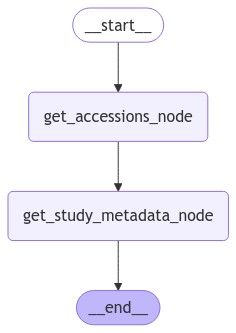

In [18]:
from IPython.display import Image
Image(subgraph.get_graph().draw_mermaid_png())

In [19]:
# Call the graph and stream
input = {"entrez_id" : "36098095", "database" : "sra"}
#input = {"entrez_id" : "36029097", "database" : "sra"}
config = {"max_concurrency" : 3, "recursion_limit": 30}
final_step = None
for step in subgraph.stream(input, subgraphs=True, config=config):
    print(step)
    final_step = step

(('get_accessions_node:3637968d-e510-517e-faf2-739934fe5941',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3LNRvps0EnM9KaOsRLGUNCga', 'function': {'arguments': '{"message":"Fetch the SRA study accessions for Entrez ID 36098095."}', 'name': 'invoke_efetch_worker'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 955, 'total_tokens': 987, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2cb42d3b-8a05-426f-936e-1975b3838da3-0', tool_calls=[{'name': 'invoke_efetch_worker', 'args': {'message': 'Fetch the SRA study accessions for Entrez ID 36098095.'}, 'id': 'call_3LNRvps0EnM9KaOsRLGUNCga', 